##**Supplementary**



In [ ]:
import numpy as np
import pandas as pd
import rasterio
from rasterio.plot import show
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [ ]:
# load data

folder_path = 'E://temperature_data'
temp_tif = []

# specify the NoData value from the original file
NODATA_VALUE = -3.3999999521443642e+38

# extract month and year info
for file in os.listdir(folder_path):
    if file.endswith('.tif'):
        try:
            month = file.split('_')[2]
            year_range = file.split('_')[3].replace('.tif', '')

            tif_file_path = os.path.join(folder_path, file)

            with rasterio.open(tif_file_path) as dataset:

                band = dataset.read(1)

                band = np.ma.masked_equal(band, NODATA_VALUE)

                # reduce spatial resolution by a factor of 4
                data_resampled = dataset.read(
                    out_shape=(
                        dataset.count,
                        int(dataset.height // 4),
                        int(dataset.width // 4)
                    ),
                    resampling=Resampling.average  # use average to aggregate pixel values
                )

                # mask NoData values in the resampled data
                data_resampled = np.ma.masked_equal(data_resampled, NODATA_VALUE)


                resampled_file_path = os.path.join(folder_path, f'resampled_{file}')
                with rasterio.open(
                    resampled_file_path, 'w',
                    driver='GTiff',
                    height=data_resampled.shape[1],
                    width=data_resampled.shape[2],
                    count=dataset.count,
                    dtype=data_resampled.dtype,
                    crs=dataset.crs,
                    transform=dataset.transform * dataset.transform.scale(
                        dataset.width / data_resampled.shape[2],
                        dataset.height / data_resampled.shape[1]
                    ),
                    nodata=NODATA_VALUE
                ) as resampled_dataset:
                    resampled_dataset.write(data_resampled.filled(NODATA_VALUE))


            temp_tif.append({
                'Year_Range': year_range,
                'Month': month,
                'Resampled_TIF_File': resampled_file_path
            })

        except IndexError:
            print(f"Error processing file: {file}")

# verify the result after resampling
tif_file = temp_tif[0]['Resampled_TIF_File']


with rasterio.open(tif_file) as src:
    nodata_value = src.nodata
    print(f"Reported NoData value in resampled file: {nodata_value}")


    data = src.read(1)
    masked_data = np.ma.masked_equal(data, nodata_value)

    print(f"Min temperature (ignoring NoData): {masked_data.min()}")
    print(f"Max temperature: {masked_data.max()}")
    print(f"Masked (NoData) count: {np.ma.count_masked(masked_data)}")


Reported NoData value in resampled file: -3.3999999521443642e+38
Min temperature (ignoring NoData): -39.01080322265625
Max temperature: 21.130748748779297
Masked (NoData) count: 890877


In [ ]:
# transform the data to csv file
all_data = []


for entry in temp_tif:
    tif_file = entry['Resampled_TIF_File']
    year_range = entry['Year_Range']
    month = entry['Month']


    with rasterio.open(tif_file) as src:
        band = src.read(1)
        nodata_value = src.nodata


        band_masked = np.ma.masked_equal(band, nodata_value)

        transform = src.transform

        rows, cols = band_masked.shape

        for row in range(rows):
            for col in range(cols):
                if not band_masked.mask[row, col]:

                    x, y = transform * (col, row)
                    temperature = band_masked[row, col]


                    all_data.append([year_range, month, x, y, temperature])

# convert all the data to a single DataFrame
df_all = pd.DataFrame(all_data, columns=['year_range', 'month', 'longitude', 'latitude', 'temperature'])

df_all.head(10)



,year_range,month,longitude,latitude,temperature
0,1961-1990,1,-75.266704,83.266643,-35.638374
1,1961-1990,1,-75.200037,83.266643,-35.627083
2,1961-1990,1,-75.133370,83.266643,-35.604168
3,1961-1990,1,-74.933371,83.266643,-35.562626
4,1961-1990,1,-74.866704,83.266643,-35.547085
5,1961-1990,1,-74.800037,83.266643,-35.531750
6,1961-1990,1,-74.733371,83.266643,-35.516541
7,1961-1990,1,-74.666704,83.266643,-35.501419
8,1961-1990,1,-74.600037,83.266643,-35.486290
9,1961-1990,1,-74.533371,83.266643,-35.470791


In [ ]:
# save to a CSV file
output_csv_path = 'E://temperature_data//temperature_data_subsampling.csv'
df_all.to_csv(output_csv_path, index=False)

print(f"Data saved to {output_csv_path}")


NameError: name 'df_all' is not defined

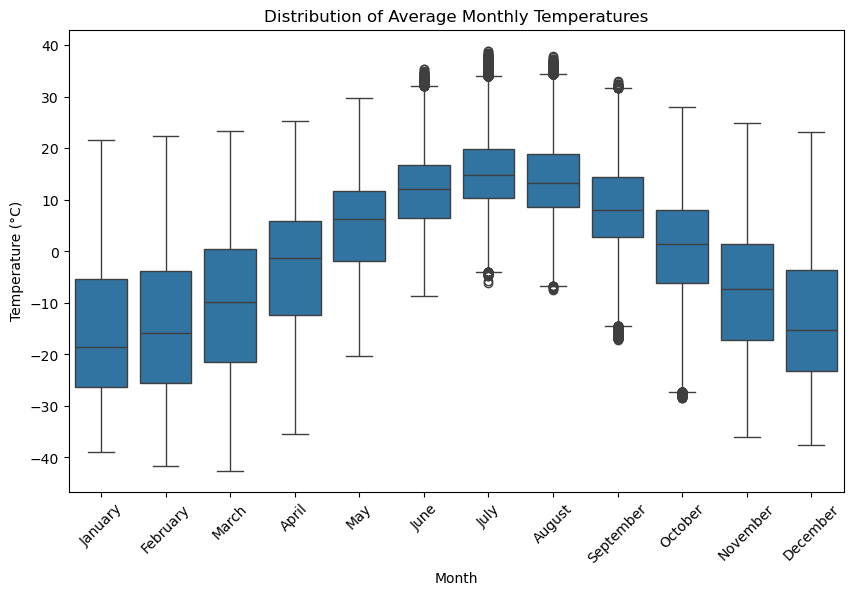

In [ ]:
# convert month names
df_all['month'] = df_all['month'].astype(int)
df_all['month_name'] = pd.to_datetime(df_all['month'], format='%m').dt.month_name()


plt.figure(figsize=(10, 6))
sns.boxplot(x='month_name', y='temperature', data=df_all, order=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.title('Distribution of Average Monthly Temperatures')
plt.xticks(rotation=45)
plt.ylabel('Temperature (°C)')
plt.xlabel('Month')

# Save the figure to PNG
fig = plt.gcf()
fig.savefig('E://temperature_data//graphs//temperature_whole_dataset.png', dpi=300)

plt.show()

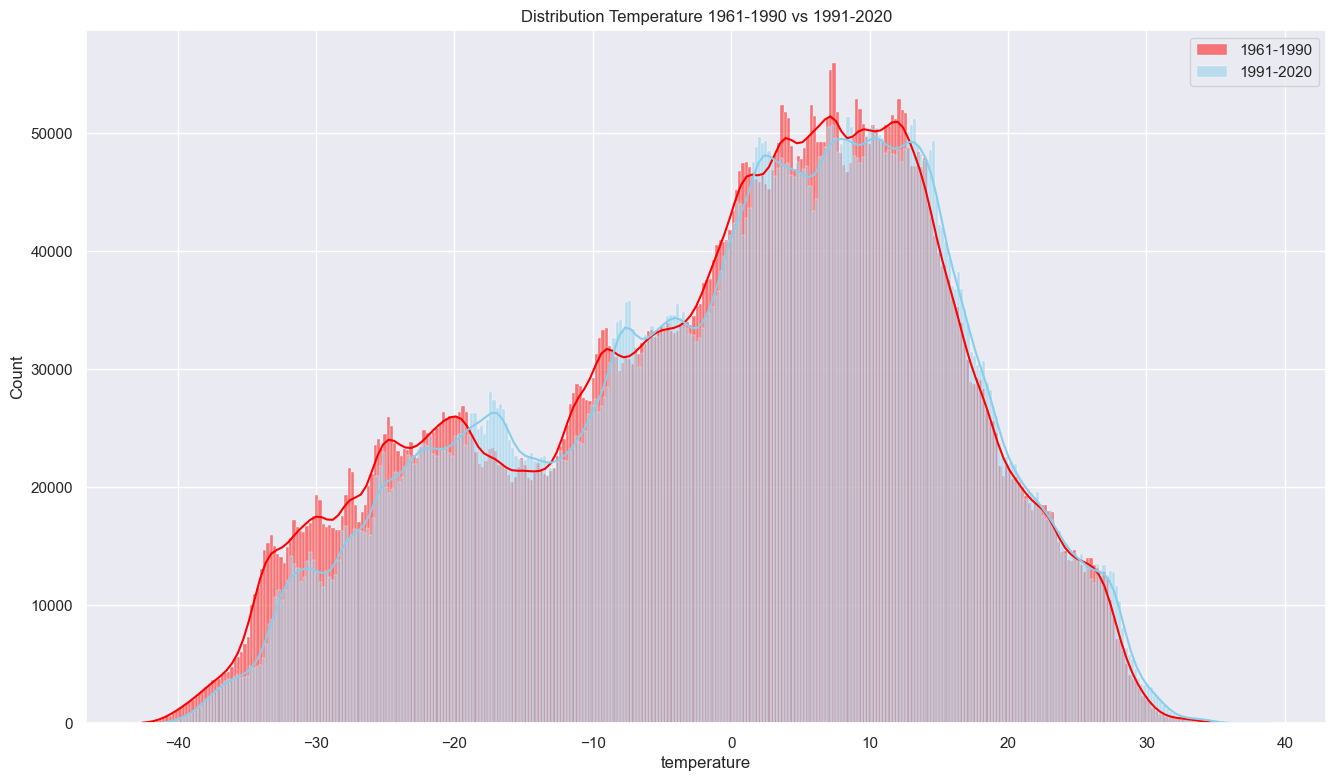

In [ ]:
sns.set_theme(style="darkgrid")
dim =(16,9)
fig, xyz = plt.subplots(figsize=dim)
sns.histplot(dt_1['temperature'], color="red", label="1961-1990", kde=True).set_title("Distribution Temperature 1961-1990 vs 1991-2020")
sns.histplot(dt_2['temperature'], color="skyblue", label="1991-2020", kde=True)
plt.legend()

fig = plt.gcf()
fig.savefig('E://temperature_data//graphs//distribution.png', dpi=300)

plt.show()

Vizual Analysis of Distributions:
question: "What is the distribution of average monthly temperatures across the two year ranges (1961-1990 and 1991-2010)?"
Based on this plot, we can answer the question as follows:
Both 30 years range 1961-1990 and 1991-2010 don't follow a normal distribution and apparently they follow similar distributions. However, it clear to note vizually that the first 30 years contain more extreme peaks on the left side representing more cold teperatures than the second 30 years. It can be said that in the 1st 30 years the cold temperatures had more extremes than the second 30 years. A slightly difference on the tail in the right side, warmer temperatures for the second 30 years indicated that there were more warmer temepatures than the first 30 years range. Therefore, there are observable differences in the distribution of average monthly temperatures between the two periods particularly on the tails. In general, we can state that during lower tempeartures seassons the first 30 years have more negative temperatures, since the tails has more data than the second 30 years. For warming temperatures, particularly in spring both distributions seems to keep the same pace, and for summer seasons the second 30 years present a slitghtly elevated temperature than the first 30 years. The variability in temperature distributions appears relatively consistent across both periods and seassons, though extreme temperatures in summer are more prevalent in the later period and lower tempeartues in initial 30 year period.

In [ ]:
dt_1 = pd.DataFrame(df_all[df_all["year_range"].str.contains("1961-1990")])
dt_2 = pd.DataFrame(df_all[df_all["year_range"].str.contains("1991-2020")])
dt_1['temperature']

0          -35.638374
1          -35.627083
2          -35.604168
3          -35.562626
4          -35.547085
              ...    
15527824    22.073584
15527825    22.081333
15527826    22.099667
15527827    22.163000
15527828    22.178125
Name: temperature, Length: 8101476, dtype: float32

In [ ]:
# categorize data into seasons
# create season column based on months
df_all['season'] = pd.cut(df_all['month'], bins=[0, 2, 5, 8, 11, 12],
                          labels=['Winter', 'Spring', 'Summer', 'Fall', 'Winter2'], right=False)

# using 'Winter' to replace 'Winter2' for Dec, Jan, Feb
df_all['season'] = df_all['season'].replace('Winter2', 'Winter')


C:\Users\cb7en\AppData\Local\Temp\ipykernel_23128\305878110.py:7: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_all['season'] = df_all['season'].replace('Winter2', 'Winter')


 2: is there any significent difference between sensons?
 During the 4 seassons the mean temperatures for the second 30 years is slightly higher than the previous. In the Winter the first 30 years has a data with higher standard Deviation demonstrating that there were more extreme lower temperatures than the second 30 years. Sprint seasson fallows the same patern, where first 30 years has a higher volatility genarint extreme teperatures than the the second 30 years, and wamer temperatues are located in the second 30 years range. IN the Summer we see a significant quantity of outliers from both years, but the second 30 years have a little more extreme temperatures. The Fall confirms that for first 30 years the lower temperatures were more constant reaching lows and extremes than the second 30 years.

In [ ]:
#df[(df[Gender]=='Male') & (df[Year]==2014)]
w1 = pd.DataFrame(dt_1[(dt_1['year_range']=="1961-1990") & (dt_1['month_name']=="March")])
w2 = pd.DataFrame(dt_1[(dt_1['year_range']=="1961-1990") & (dt_1['month_name']=="April")])
w3 = pd.DataFrame(dt_1[(dt_1['year_range']=="1961-1990") & (dt_1['month_name']=="May")])
winter1 = pd.concat([w1, w2, w3], ignore_index=True)

In [ ]:
w1

,year_range,month,longitude,latitude,temperature,month_name
2700492,1961-1990,3,-75.266704,83.266643,-36.799667,March
2700493,1961-1990,3,-75.200037,83.266643,-36.787918,March
2700494,1961-1990,3,-75.133370,83.266643,-36.766167,March
2700495,1961-1990,3,-74.933371,83.266643,-36.724457,March
2700496,1961-1990,3,-74.866704,83.266643,-36.709084,March
...,...,...,...,...,...,...
3375610,1961-1990,3,-77.400036,25.066667,22.811865,March
3375611,1961-1990,3,-77.333370,25.066667,22.808893,March
3375612,1961-1990,3,-77.266703,25.066667,22.822834,March
3375613,1961-1990,3,-76.200037,25.066667,22.680790,March


In [ ]:
w21 = pd.DataFrame(dt_2[(dt_2['year_range']=="1991-2020") & (dt_2['month_name']=="March")])
w22 = pd.DataFrame(dt_2[(dt_2['year_range']=="1991-2020") & (dt_2['month_name']=="April")])
w23 = pd.DataFrame(dt_2[(dt_2['year_range']=="1991-2020") & (dt_2['month_name']=="May")])
winter2 = pd.concat([w21, w22, w23], ignore_index=True)

In [ ]:
print("1st 30yrs")
print("Standar Deviation =",winter1['temperature'].std())
print("Max =",winter1['temperature'].max())
print("Min =",winter1['temperature'].min())

1st 30yrs
Standar Deviation = 14.125460240664287
Max = 28.82675
Min = -42.534073


In [ ]:
print("2nd 30yrs")
print("Standar Deviation =",winter2['temperature'].std())
print("Max =",winter2['temperature'].max())
print("Min =",winter2['temperature'].min())

2nd 30yrs
Standar Deviation = 13.705570890136201
Max = 29.623459
Min = -41.013313


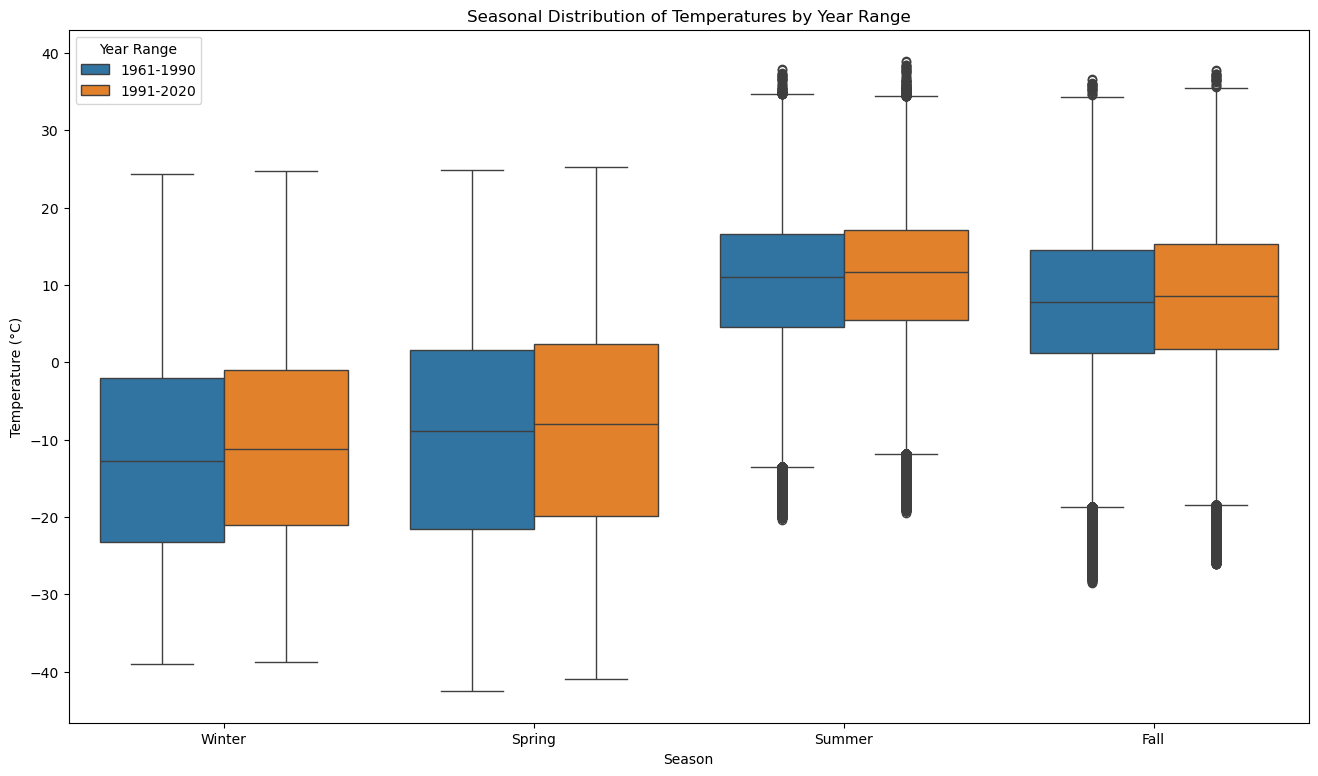

In [ ]:
# distribution of Temperatures by Season and Year Range
plt.figure(figsize=(16, 9))
sns.boxplot(x='season', y='temperature', hue='year_range', data=df_all)
plt.title('Seasonal Distribution of Temperatures by Year Range')
plt.ylabel('Temperature (°C)')
plt.xlabel('Season')
plt.legend(title='Year Range')

# Save the figure to PNG
fig = plt.gcf()
fig.savefig('E://temperature_data//graphs//two_yearrange_seasonal.png', dpi=300)


plt.show()


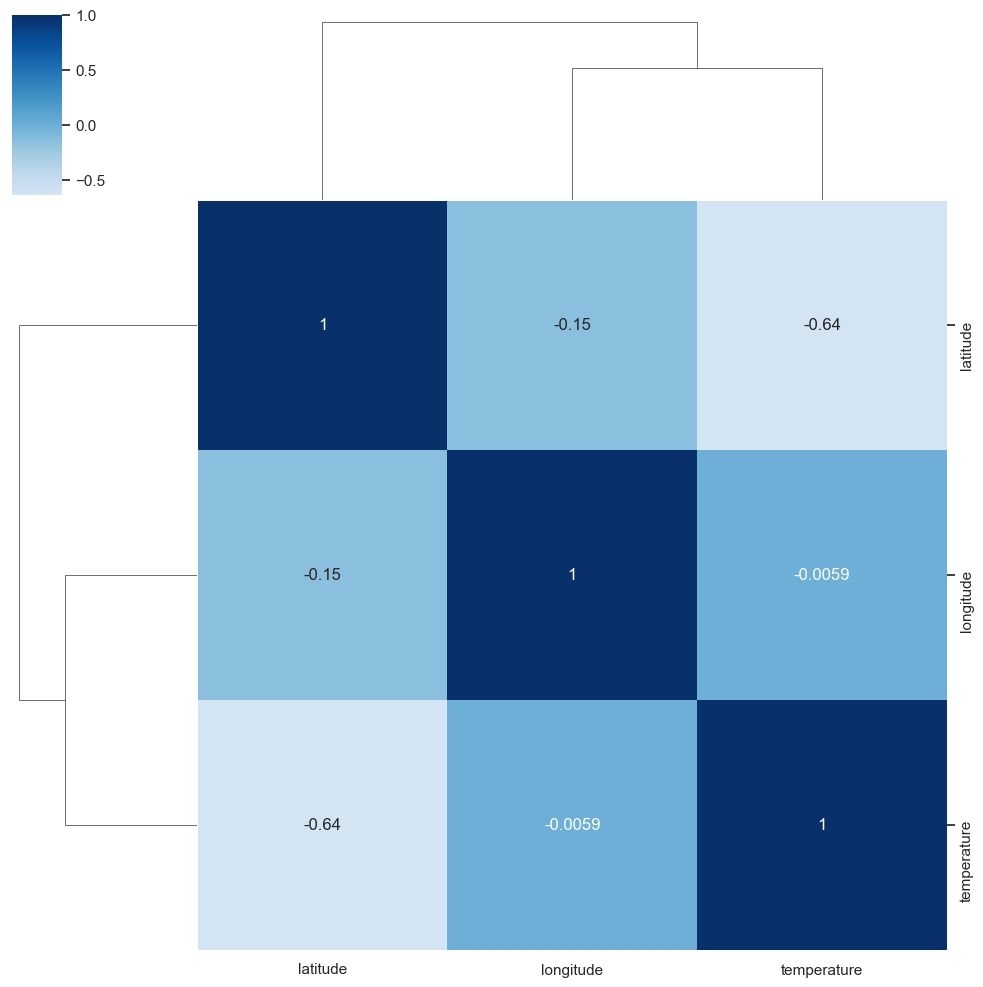

In [ ]:
sns.clustermap(df_all.drop(columns=['year_range','month','month_name']).corr('spearman'), annot=True, center = 0, cmap='Blues');
fig = plt.gcf()
fig.savefig('E://temperature_data//graphs//corrolation.png', dpi=300)

In [ ]:
dt_2.head(3)

,year_range,month,longitude,latitude,temperature,month_name
675123,1991-2020,1,-75.266704,83.266643,-35.131290,January
675124,1991-2020,1,-75.200037,83.266643,-35.119500,January
675125,1991-2020,1,-75.133370,83.266643,-35.096416,January


In [ ]:
# load the dataset
df_all = pd.read_csv(r"E:\temperature_data\temperature_data_subsampling.csv")
df_all.head(10)

,year_range,month,longitude,latitude,temperature,month_name
0,1961-1990,1,-75.266704,83.266643,-35.638374,January
1,1961-1990,1,-75.200037,83.266643,-35.627083,January
2,1961-1990,1,-75.133370,83.266643,-35.604168,January
3,1961-1990,1,-74.933371,83.266643,-35.562626,January
4,1961-1990,1,-74.866704,83.266643,-35.547085,January
5,1961-1990,1,-74.800037,83.266643,-35.531750,January
6,1961-1990,1,-74.733371,83.266643,-35.516540,January
7,1961-1990,1,-74.666704,83.266643,-35.501420,January
8,1961-1990,1,-74.600037,83.266643,-35.486290,January
9,1961-1990,1,-74.533371,83.266643,-35.470790,January


In [ ]:
dt_1 = pd.DataFrame(df_all[df_all["year_range"].str.contains("1961-1990")])
dt_2 = pd.DataFrame(df_all[df_all["year_range"].str.contains("1991-2020")])
dt_1['temperature']

0          -35.638374
1          -35.627083
2          -35.604168
3          -35.562626
4          -35.547085
              ...    
15527824    22.073584
15527825    22.081333
15527826    22.099667
15527827    22.163000
15527828    22.178125
Name: temperature, Length: 8101476, dtype: float64

In [ ]:
dt_1.head(10)

,year_range,month,longitude,latitude,temperature,month_name
0,1961-1990,1,-75.266704,83.266643,-35.638374,January
1,1961-1990,1,-75.200037,83.266643,-35.627083,January
2,1961-1990,1,-75.133370,83.266643,-35.604168,January
3,1961-1990,1,-74.933371,83.266643,-35.562626,January
4,1961-1990,1,-74.866704,83.266643,-35.547085,January
5,1961-1990,1,-74.800037,83.266643,-35.531750,January
6,1961-1990,1,-74.733371,83.266643,-35.516540,January
7,1961-1990,1,-74.666704,83.266643,-35.501420,January
8,1961-1990,1,-74.600037,83.266643,-35.486290,January
9,1961-1990,1,-74.533371,83.266643,-35.470790,January


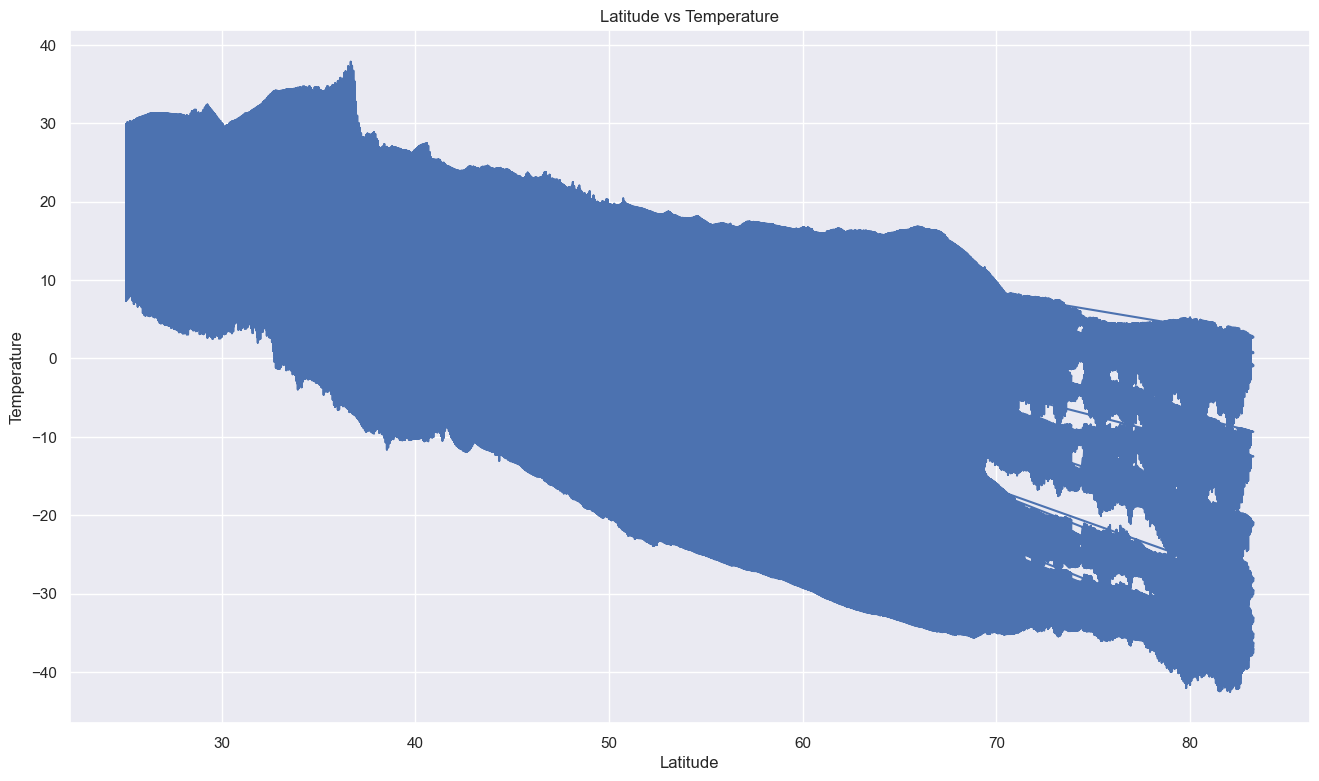

In [ ]:
fig,ax = plt.subplots(figsize=(16,9))

x = dt_1['latitude']
y = dt_1['temperature']

plt.plot(x, y)
plt.xlabel('Latitude')
plt.ylabel('Temperature')
plt.title('Latitude vs Temperature')

fig = plt.gcf()
fig.savefig('E://temperature_data//graphs//latitude.png', dpi=300)

plt.show()

In [ ]:
Question 5:

Research question 1 : What is the relationship between these 2 variables (Full Data)?
Using Spearmans correlation table that measures the strength and direction of association between these two variables, Latitude and Temperature
demonstrated to be negativelly correlated -0.64. It is important to use Spearm method because it assumes that the variables don't behave
in a normal distribution. The assessment makes confirm the expected due to the fact that geographically higher latitudes reprsents closer distances
from the Noth or South Poles where the temperature is lower.


In [ ]:
dt_1['temperature'].pct_change()

0                NaN
1          -0.000317
2          -0.000643
3          -0.001167
4          -0.000437
              ...   
15527824    0.000594
15527825    0.000351
15527826    0.000830
15527827    0.002866
15527828    0.000682
Name: temperature, Length: 8101476, dtype: float64

In [ ]:
dt_1.describe()

,month,longitude,latitude,temperature
count,8.101476e+06,8.101476e+06,8.101476e+06,8.101476e+06
mean,6.500000e+00,-1.037211e+02,5.481085e+01,-1.152501e+00
std,3.452053e+00,2.441788e+01,1.358993e+01,1.583044e+01
min,1.000000e+00,-1.680000e+02,2.506667e+01,-4.253407e+01
25%,3.750000e+00,-1.182667e+02,4.439999e+01,-1.261328e+01
50%,6.500000e+00,-1.022000e+02,5.559999e+01,1.422688e+00
75%,9.250000e+00,-8.513337e+01,6.546665e+01,1.106323e+01
max,1.200000e+01,-5.266671e+01,8.326664e+01,3.787288e+01


In [ ]:
dt_2.describe()

,month,longitude,latitude,temperature
count,8.101476e+06,8.101476e+06,8.101476e+06,8.101476e+06
mean,6.500000e+00,-1.037211e+02,5.481085e+01,-7.899861e-02
std,3.452053e+00,2.441788e+01,1.358993e+01,1.539649e+01
min,1.000000e+00,-1.680000e+02,2.506667e+01,-4.101331e+01
25%,3.750000e+00,-1.182667e+02,4.439999e+01,-1.118536e+01
50%,6.500000e+00,-1.022000e+02,5.559999e+01,2.200552e+00
75%,9.250000e+00,-8.513337e+01,6.546665e+01,1.178601e+01
max,1.200000e+01,-5.266671e+01,8.326664e+01,3.892229e+01


In [3]:
# code for shinyapps
import pandas as pd
import plotly.express as px
from shiny.express import input, ui, render
from shinywidgets import render_plotly, render_altair
from pathlib import Path
from shiny import reactive
import matplotlib.pyplot as plt



ui.page_opts(title="Temperature Distribution", fillable=True)

@reactive.calc
def dat():
    infile = Path(__file__).parent / "temperature_data_binned.csv"
    df = pd.read_csv(infile)

    #define the correct order for months
    month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

    #convert 'month_name' to a categorical type with order
    df['month_name'] = pd.Categorical(df['month_name'], categories=month_order, ordered=True)

    return df.head(100)


# input selector for user to choose the variable
ui.input_selectize("var", "Select variable", choices=["month_name", "latitude"])


with ui.sidebar():
    ui.input_slider("n", "Number of Data Points", 1, 100, 10)

# to render the Altair bar graph
@render_altair
def hist():
    import altair as alt

    df = dat()

    selected_var = input.var()

    if selected_var == "month_name":
        x_encoding = alt.X('month_name:N', title='Month', sort=[
            'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'
        ])
    else:
        x_encoding = alt.X('latitude:Q', title='Latitude')

    return (
        alt.Chart(df)
        .mark_bar()
        .encode(
            x=x_encoding,
            y=alt.Y('mean(temperature):Q', title='Average Temperature')
        )
    )

# render the Matplotlib histogram
@render.plot(alt="Temperature Distribution Histogram")
def histogram():
    temperature_data = dat()['temperature']

    n = input.n()
    data_to_plot = temperature_data.head(n)

    plt.clf()

    plt.hist(data_to_plot, bins=10, density=True, alpha=0.75)
    plt.title(f"Temperature Distribution for First {n} Data Points")
    plt.xlabel("Temperature")
    plt.ylabel("Density")



ModuleNotFoundError: No module named 'shiny'